In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import io
from scipy.stats import gaussian_kde
import seaborn as sns 
import h5py
import os
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
data_loc = "../../dnn-spacings-data/hessian_spectra/Bike/MLP"

N.B. for an MLP model, this takes a long time for the test set. Train set would take several days (with a GPU), we estimate, so restrict to test set.

In [3]:
dataset = "test"
# dataset = "train"

In [4]:
figure_dir = "../figures/{}/{}".format(data_loc.split("/")[-1], dataset)
os.makedirs(figure_dir, exist_ok=True)

# Single spectrum - MISSING

For an MLP, this just requires too much memory. We'll stick to batch computations.

We study the spectrum of a logistic regression Hessian computed over the entire dataset.

In [5]:
def wigner_surmise(s):
    return np.pi*s/2*np.exp(-np.pi*s**2/4)

In [ ]:
fin = h5py.File(os.path.join(data_loc, "bsall_{}.hdf5".format(dataset)), "r")
eigvals = np.sort(np.array(fin["hessian_evals"]).ravel())
fin.close()

In [ ]:
sns.distplot(eigvals, kde=False, norm_hist=True);

Got issues with large outliers for visualisation.

In [ ]:
sns.distplot(eigvals[:-200], kde=False, norm_hist=True);

There's a lot of degeneracy here - we'll need to remove that.

In [ ]:
min_val = 1e-5
truncated_eigvals = eigvals[np.abs(eigvals)>min_val]
sns.distplot(truncated_eigvals[:-200], kde=False, norm_hist=True);

### Unfolding

Let's try smoothing the spectrum to perform the unfolding.

In [ ]:
kde = gaussian_kde(truncated_eigvals)

In [ ]:
x = np.linspace(np.min(truncated_eigvals)-0.5, np.max(truncated_eigvals)/30, 200)
plt.plot(x, kde.pdf(x));

This is straight from the definition of unfolding.

In [ ]:
min_val = np.min(truncated_eigvals) - 1
unfolded_eigvals = np.zeros_like(truncated_eigvals)
for i, eigval in tqdm(enumerate(truncated_eigvals)):
    unfolded_eigvals[i] = kde.integrate_box_1d(min_val, eigval)

In [ ]:
sns.distplot(unfolded_eigvals, kde=False, norm_hist=True);

In [ ]:
diffs = unfolded_eigvals[1:] - unfolded_eigvals[:-1]

In [ ]:
sns.distplot(diffs, kde=False, norm_hist=True);
np.mean(diffs)

Doesn't work at all. This is not necesssarily a statement about the spectrum in question, but rather that the unfolding cannot be performed correctly with only one example spectrum.

### Spacing ratios

Let's try the spacing ratio approach from arXiv:1212.5611, which removes the unfolding step.


In [6]:
def ratio_surmise(r):
    """
    From arXiv:1212.5611
    """
    return 27*((r + r**2)/(1 + r + r**2)**(5/2))/8

In [ ]:
spacings = truncated_eigvals[1:] - truncated_eigvals[:-1]
ratios = spacings[1:]/spacings[:-1]

In [ ]:
sns.distplot(ratios, kde=False);

Looks like we might need to truncate.

In [ ]:
ratio_truncs = np.linspace(5, 15, 3).astype(int)
ratio_truncs = [10]
fig = plt.figure(figsize=(4, 4));
# fig.suptitle("MNIST Logistic Hessian spectra --- Full dataset --- Ratio of successive spacings")

for plot_ind, ratio_trunc in enumerate(ratio_truncs):
    plot_ratios = ratios[ratios < ratio_trunc]
#     sns.distplot(plot_ratios, kde=False, norm_hist=True, label="data", color='mediumblue');
    plt.hist(plot_ratios, label="data", density=True, color="darkblue", bins=35)
    x = np.linspace(np.min(plot_ratios), np.max(plot_ratios), 1000)
    plt.plot(x, ratio_surmise(x), label="$P(r)$", c='r', linewidth=2);
    plt.xlabel("$r$", fontsize=20);
#     plt.title("Truncate ratios above {}".format(ratio_trunc));
    plt.legend(fontsize=20);
plt.tight_layout();
plt.savefig(os.path.join(figure_dir, "fulldata_spacing_ratios.pdf"))

Success!

## Many spectra

We use pre-computed spectra of Hessians of logistic regression on MNIST computed over batches. Obtained using code in [GadamX](https://github.com/diegogranziol/GadamX).

##### Read the data

In [9]:
fin = h5py.File(os.path.join(data_loc, "bs64_{}.hdf5".format(dataset)), "r")
spectra = np.sort(np.array(fin["hessian_evals"]))
fin.close()

In [10]:
spectra.shape

(218, 16601)

In [11]:
def semi_circle(x):
    z = 4 - x**2
    return (z>=0)*np.sqrt(z)/(2*np.pi)

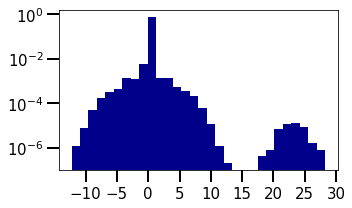

In [12]:
min_val = 1e-5
plt.figure(figsize=(5,3));
eigvals = np.concatenate(spectra)
eigvals = eigvals/(2*np.sqrt(spectra.shape[1]))
plt.hist(eigvals, density=True, color="darkblue", bins=30, label="Data");
x = np.linspace(np.min(eigvals)-0.01, np.max(eigvals)+0.01, 1000)
# plt.plot(x, semi_circle(x), label="Semi-circle", c='r');
plt.yscale('log')
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
# plt.legend();
plt.tight_layout();
plt.savefig(os.path.join(figure_dir, "batchdata_global.pdf"))

### Unfolding 


Divide the spectra into two sets and use one set to estimate the mean level density to unfold the other set.



##### Function to do unfolding

Adapted from [unfoldr](https://github.com/tscholak/unfoldr). The algorithm is identical, we have just stripped away a lot of unecessary code to produce a single, easily understood function for use here. We've also swapped Cython for numba, for readability.

The logic here is the sort of nasty thing that doesn't fit easily into `numpy`. In pure Python, the loops and conditions are curshingly slow. **Numba jit magic makes this 100s x faster - think hard before  turning it off.

In [13]:
n_unfold = int(spectra.shape[0]/3)
print(n_unfold)

72


In [14]:
from numba import jit 

@jit(nopython=True)
def unfold(eigenvalues, unfolding_pool, num_unfolding_spectra):
    """
    Spectra are of size n. Then L=n*num_unfolding_spectra/(1+num_unfolding_spectra).
    
    :param eigenvalues: array-like of shape (n,) -- the spectrum to be unfolded (sorted ascending)
    :param unfolding pool: array-like of shape (L, ) -- the (sorted) evals to use to determine mean spacing.
    :param num_unfolding_spectra: int -- the number of spectra (of size n) combined to give unfolding_pool.
    
    :return: np.ndarray of shape (n - 1) -- the unfolded eigenvalues spacings.
    """
    level_spacing = np.zeros(len(eigenvalues)-1)
    number_of_eigenvalues = len(eigenvalues)
    len_unfold_pool = len(unfolding_pool)
    p = num_unfolding_spectra
    i = 0
    for j in range(number_of_eigenvalues):
        while (i<len_unfold_pool) and (unfolding_pool[i] < eigenvalues[j]):
            i += 1
        if j + 1 < number_of_eigenvalues:
            level_spacing[j] -= i / (p)
        if j > 0:
            level_spacing[j-1] += i / (p)
    return level_spacing

/Users/nicholasbaskerville/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


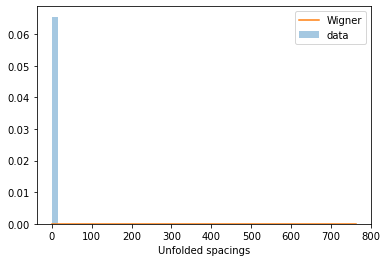

In [15]:
spectra_to_unfold = np.sort(spectra[:n_unfold, :], axis=1).copy()
n_unfold_pool = spectra.shape[0] - n_unfold
unfolding_pool = np.sort(spectra[n_unfold:, :].ravel()).copy()
unfolded_spectra = np.concatenate([unfold(spectrum, unfolding_pool, n_unfold_pool) for spectrum in tqdm(spectra_to_unfold)])
sns.distplot(unfolded_spectra, kde=False, norm_hist=True, label='data');
x = np.linspace(np.min(unfolded_spectra), np.max(unfolded_spectra))
plt.plot(x, wigner_surmise(x), label="Wigner");
plt.legend();

plt.xlabel("Unfolded spacings");

There's some degeneracy which is distoriting things. We will need to truncate the spectra somehow.

First let's try taking only the top N eigenvalues from each spectrum.

/Users/nicholasbaskerville/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


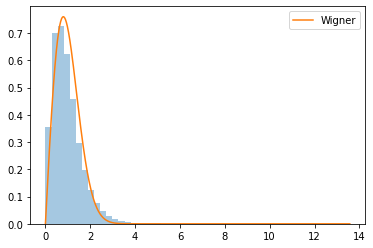

In [16]:
top_N = 2000

spectra_to_unfold = np.sort(spectra[:n_unfold, :], axis=1)[:, -top_N:]
n_unfold_pool = spectra.shape[0] - n_unfold
unfolding_pool = np.sort(np.sort(spectra[n_unfold:, :], axis=1)[:, -top_N:].ravel())
unfolded_spectra = [unfold(spectrum, unfolding_pool, n_unfold_pool) for spectrum in tqdm(spectra_to_unfold)]
unfolded_spectra = np.concatenate(unfolded_spectra);
sns.distplot(unfolded_spectra, kde=False, norm_hist=True);
x = np.linspace(np.min(unfolded_spectra), np.max(unfolded_spectra), 1000)
plt.plot(x, wigner_surmise(x), label='Wigner');
plt.legend();

Looks okay. There's clearly repulsion.

Taking the top N eigenvalues feels clunky. It would be more elegant to impose a spectral cut-off.

<ipython-input-17-a594b92d5f21>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(min_vals), n_smaller);


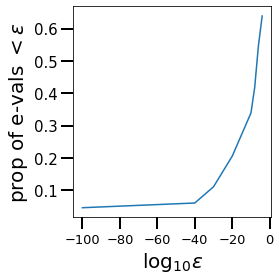

In [17]:
plt.figure(figsize=(4,4))
min_vals = [1e-500, 1e-100, 1e-40, 1e-30, 1e-20, 1e-10, 1e-8, 1e-6, 1e-4]
n_smaller = [np.sum(np.abs(spectra) < min_val)/np.prod(spectra.shape) for min_val in min_vals]
plt.plot(np.log10(min_vals), n_smaller);
# plt.xscale('log');
plt.xlabel("$\log_{10}\epsilon$", fontsize=20);
plt.ylabel("prop of e-vals $< \epsilon$", fontsize=20);
xticks = plt.xticks(fontsize=13)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
# ax.ticklabel_format(axis='x', style='sci', scilimits=(-500, -4))
plt.tight_layout();
plt.savefig(os.path.join(figure_dir, "proportion_hessian_evals_below_cutoff.pdf"))

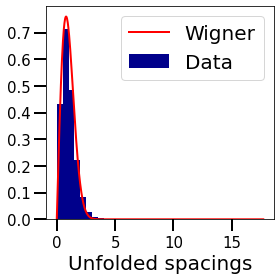

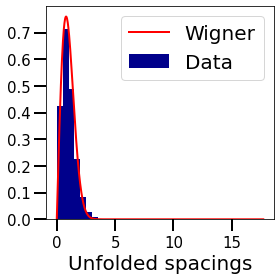

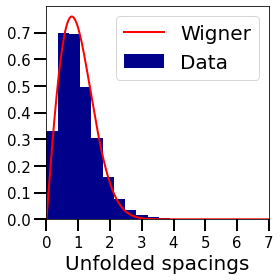

In [18]:
min_vals = [0, 1e-20]
spacing_trunc = 7


for plot_ind, min_val in tqdm(enumerate(min_vals), total=len(min_vals)):
    plt.figure(figsize=(4,4))
    spectra_to_unfold = spectra[:n_unfold, :].copy()
    spectra_to_unfold = [np.sort(spectrum[np.abs(spectrum) > min_val]) for spectrum in spectra_to_unfold]

    n_unfold_pool = spectra.shape[0] - n_unfold
    unfolding_pool = spectra[n_unfold:, :].copy()
    unfolding_pool = np.sort(np.concatenate([spectrum[np.abs(spectrum) > min_val] for spectrum in unfolding_pool]))

    unfolded_spectra = np.concatenate([unfold(spectrum, unfolding_pool, n_unfold_pool) for spectrum in tqdm(spectra_to_unfold, leave=False)])

    plt.hist(unfolded_spectra, label="Data", density=True, color="darkblue", bins=35)
    x = np.linspace(np.min(unfolded_spectra), np.max(unfolded_spectra), 1000)
    plt.plot(x, wigner_surmise(x), label="Wigner", c='r', linewidth=2);
    

    plt.legend(fontsize=20);
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.tick_params(length=12, width=2)
    plt.xlabel("Unfolded spacings", fontsize=20);
    plt.tight_layout();
    plt.savefig(os.path.join(figure_dir, "bs64_unfolding_trunc{}.pdf".format(plot_ind)))
    plt.show()
    
    if plot_ind == len(min_vals) - 1:
        plt.figure(figsize=(4,4))
#         unfolded_spectra = unfolded_spectra[unfolded_spectra < spacing_trunc]
        plt.hist(unfolded_spectra, label="Data", density=True, color="darkblue", bins=50)
        x = np.linspace(np.min(unfolded_spectra), np.max(unfolded_spectra), 1000)
        plt.plot(x, wigner_surmise(x), label="Wigner", c='r', linewidth=2);
        plt.xlim([0, spacing_trunc])

        plt.legend(fontsize=20);
        xticks = plt.xticks(fontsize=15)
        yticks = plt.yticks(fontsize=15)
        ax = plt.gca()
        ax.tick_params(length=12, width=2)
        plt.xlabel("Unfolded spacings", fontsize=20);
        plt.tight_layout();
        plt.savefig(os.path.join(figure_dir, "bs64_unfolding_trunc{}_uppertrunc.pdf".format(plot_ind)))
        plt.show()
        
#     sns.distplot(unfolded_spectra, kde=False, norm_hist=True, label="data");
#     x = np.linspace(np.min(unfolded_spectra), np.max(unfolded_spectra))
#     plt.plot(x, wigner_surmise(x), label="Wigner");
#     plt.legend();
#     plt.xlabel("Unfolded spacings");



### Spacing ratios

In [19]:
def ratio_surmise(r):
    """
    From arXiv:1212.5611
    """
    return 27*((r + r**2)/(1 + r + r**2)**(5/2))/8

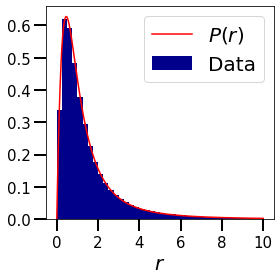

In [20]:
min_val = 1e-10
ratio_trunc = 10

fig = plt.figure(figsize=(4, 4));

sorted_spectra = [np.sort(spectrum[np.abs(spectrum) > min_val]) for spectrum in spectra]
diffs = [ss[1:] - ss[:-1] for ss in sorted_spectra]
ratios = np.concatenate([diff[1:]/diff[:-1] for diff in diffs])
ratios = ratios[ratios < ratio_trunc]
plt.hist(ratios, density=True, label="Data", color='darkblue', bins=40);
x = np.linspace(np.min(ratios), np.max(ratios), 1000)
plt.plot(x, ratio_surmise(x), label="$P(r)$", c='r');
plt.xlabel("$r$", fontsize=20);
plt.legend(fontsize=20);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig(os.path.join(figure_dir, "batches_spacing_ratios.pdf"))